<a href="https://colab.research.google.com/github/vikpy/DLSem3/blob/master/Assignment_5_flowing_the_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagenet for model building - classifier on any three classes (synsets) of cars 

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import cv2
import PIL.Image
import urllib
import os
import pandas as pd


wnids = {
         
         'jeep' : 'n03594945',
         
         'race_car' : 'n04037443',

         'army_tank' : 'n04389033'

         }
image_net_path = 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid='
pages = {}
for wnid in wnids.keys():
  temp = requests.get(image_net_path + wnids[wnid])
  pages[wnid] = str(BeautifulSoup(temp.content, 'html.parser')).split('\r\n')

In [2]:
pages["race_car"][:5]

['http://www.upmoon.com/up7/Mitsubishi%20Eclipse%20Street%20Racing%20Car.jpg',
 'http://www.hunternet.com.au/members/uploads/images/SkidPadFront.jpg',
 'http://farm1.static.flickr.com/202/463662585_60ea3e8381.jpg',
 'http://www.cardsunlimited.com/largeimage/RacingCar.jpg',
 'http://www.iceposter.com/thumbs/A11870_b.jpg']

We will be using Flow from Directory 
![alt text](http://upscfever.com/datasets/flow_from_directory.jpeg)

In [3]:
# Making directories for the train set 
!mkdir /content/train 
!mkdir /content/train/race_car 
!mkdir /content/train/jeep 
!mkdir /content/train/army_tank 

# making directories for the test set
!mkdir /content/validation 
!mkdir /content/validation/race_car 
!mkdir /content/validation/jeep 
!mkdir /content/validation/army_tank 

# making directories for the test set 
!mkdir /content/test/ 
!mkdir /content/test/test 

In [4]:
def url_to_image(url):
  import numpy as np
  import cv2
  import urllib
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
  return image

In [5]:
n_of_training_images=150#the number of training images to use

for class_of_vehicle in pages:
  for progress in range(n_of_training_images):
      if(progress%20==0):
          print(progress)
      if not pages[class_of_vehicle][progress] == None:
        try:
          I = url_to_image(pages[class_of_vehicle][progress])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/train/' + class_of_vehicle + '/img'+str(progress)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140


In [6]:
for class_of_vehicle in pages:
  for progress in range(50):
      if(progress%20==0):
          print(progress)
      if not pages[class_of_vehicle][n_of_training_images + progress] == None:
        try:
          I = url_to_image(pages[class_of_vehicle][n_of_training_images + progress])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/validation/' + class_of_vehicle + '/img'+str(n_of_training_images + progress)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
0
20
40
0
20
40


In [7]:
for class_of_vehicle in pages:
  for progress in range(50):
      if(progress%20==0):
          print(progress)
      if not pages[class_of_vehicle][n_of_training_images + progress + 50] == None:
        try:
          I = url_to_image(pages[class_of_vehicle][n_of_training_images + progress + 50])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/test/test/'+ str(class_of_vehicle) +  '_' +str(n_of_training_images + progress + 50)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
0
20
40
0
20
40


In [8]:
# Path to the train folder
original_test = '/content/test/test'
 
filenames = os.listdir(original_test)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'race_car':
        categories.append('race_car')
    elif category == 'jeep' :
        categories.append('jeep')
    else : 
        categories.append('army_tank')

data_test = pd.DataFrame({'filename':filenames,'label':categories})

data_test.to_csv("original_test.csv",index=False)

class_mode: One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels, - "binary" will be 1D binary labels, "sparse" will be 1D integer labels, - "input" will be images identical to input images (mainly used to work with autoencoders). - If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras


# Image Augmentation

trainval_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True #,
 #   rotation_range=180,
 #   width_shift_range=0.3,
 #   height_shift_range=0.3,
 #   shear_range=0.4,
 #   zoom_range=0.4,
 #   fill_mode = 'nearest'
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Flowing the data from the directory 
batch_size = 32
train_generator = trainval_datagen.flow_from_directory(directory='/content/train/',
                                                       seed=123,
                                                       shuffle=True,
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       target_size=(150,150))

val_generator = trainval_datagen.flow_from_directory(directory='/content/validation/',                                                      
                                                       seed=123,
                                                       shuffle=True,                                                       
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       batch_size=batch_size,                                                     
                                                       target_size=(150,150))



test_generator = test_datagen.flow_from_directory(directory='/content/test/',
                                                  seed=123,
                                                  shuffle=False,                                                  
                                                  class_mode=None,
                                                  color_mode='rgb',
                                                  target_size=(150,150))



Found 267 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 101 images belonging to 1 classes.


In [10]:
# Using Initializers

#initializers = keras.initializers.glorot_normal()
#initializers = keras.initializers.glorot_uniform()
#initializers = keras.initializers.he_uniform()
initializers = keras.initializers.lecun_uniform()


# Building the model 
model = Sequential()

model.add(Conv2D(512, (150,150), padding='valid', activation='relu', input_shape=(150,150,3)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer=initializers, bias_initializer=initializers))

model.add(Dense(512, activation='relu', kernel_initializer=initializers, bias_initializer=initializers))

model.add(Dense(256, activation='relu', kernel_initializer=initializers, bias_initializer=initializers))

model.add(Dense(256, activation='relu', kernel_initializer=initializers, bias_initializer=initializers))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',  optimizer= 'sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',  optimizer= 'rmsprop', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',  optimizer= 'adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 512)         34560512  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 7

In [13]:
# Fitting the models and calling the call backs
filepath="m1_test.{epoch:02d}-{val_loss:.2f}.hdf5"
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=4, mode="min")
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode="max")
model_history = model.fit_generator(generator=train_generator, validation_data=val_generator, epochs=30, verbose=1 , callbacks=[earlystopping])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.6030
Epoch 00001: saving model to m1_test.01-0.85.hdf5
9/9 [==============================] - 15s 2s/step - loss: 0.8663 - accuracy: 0.6030 - val_loss: 0.8526 - val_accuracy: 0.6190
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.9061 - accuracy: 0.5993
Epoch 00002: saving model to m1_test.02-0.84.hdf5
9/9 [==============================] - 15s 2s/step - loss: 0.9061 - accuracy: 0.5993 - val_loss: 0.8392 - val_accuracy: 0.5810
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.6404
Epoch 00003: saving model to m1_test.03-0.90.hdf5
9/9 [==============================] - 15s 2s/step - loss: 0.8542 - accuracy: 0.6404 - val_loss: 0.8969 - val_accuracy: 0.5524
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.8706 - accuracy: 0.6142
Epoch 00004: saving model to m1_test.04-0.88.hdf5
9/9 [==============================] - 16s 2s/step 

In [14]:
model_history.history

{'accuracy': [0.6029962301254272,
  0.5992509126663208,
  0.6404494643211365,
  0.6142321825027466,
  0.5543071031570435,
  0.63670414686203,
  0.6329588294029236,
  0.5955055952072144,
  0.5992509126663208],
 'loss': [0.8663332462310791,
  0.9061248302459717,
  0.8542298078536987,
  0.8705607652664185,
  0.8687594532966614,
  0.8662580251693726,
  0.8370637893676758,
  0.8463575839996338,
  0.8210111856460571],
 'val_accuracy': [0.6190476417541504,
  0.5809524059295654,
  0.5523809790611267,
  0.5523809790611267,
  0.6285714507102966,
  0.6476190686225891,
  0.5904762148857117,
  0.6095238327980042,
  0.5523809790611267],
 'val_loss': [0.8525511026382446,
  0.8392142057418823,
  0.8968775868415833,
  0.8786531686782837,
  0.8096621036529541,
  0.8354817628860474,
  0.8770309686660767,
  0.8269329071044922,
  0.9142986536026001]}

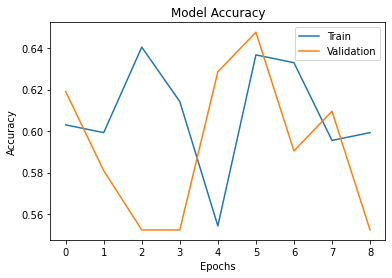

In [15]:
import matplotlib.pyplot as plt
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

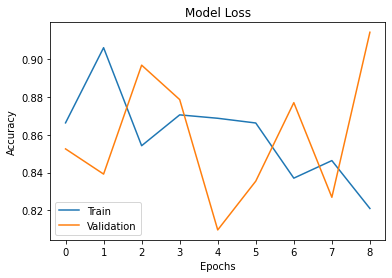

In [16]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()